# Subclassing
This tutorial will take you through subclassing {py:class}`~pimf.initialmassfunction.InitialMassFunction` for your own user defined IMFs.

_This tutorial notebook can be downloaded and ran on your own system._

We will take you through the three functions you should define in a subclass, on top of the initialisation. This initialisation step can probably be abstracted in the future.

Let's do this by implementing a [Salpeter (1995)](https://ui.adsabs.harvard.edu/abs/1955ApJ...121..161S/abstract) IMF (implemented in {py:class}`~pimf.initialmassfunction.PowerLawIMF`)

This has the form $$\xi(M) = \xi_0 M^{-2.35}$$ where $\xi(M)$ is the number of stars per mass bin. See [IMF basics](theory.md#basics) for more about different ways this could be defined.

We will need the following [integrals](theory.md#integrals-and-observables):
$$\begin{align}
\int^{M_\textrm{max}}_{M_\textrm{min}}\xi(M)\mathrm{d}M 
    &= \xi_0\frac{M^{\alpha+1}_\textrm{max} - M^{\alpha+1}_\textrm{min}}{\alpha + 1}\\
\int^{M_\textrm{max}}_{M_\textrm{min}}M\xi(M)\mathrm{d}M 
    &= \xi_0\frac{M^{\alpha+2}_\textrm{max} - M^{\alpha+2}_\textrm{min}}{\alpha + 2}.
\end{align}$$
These are the formulae for `integrate` and `integrate_product` methods respectively.

## `__init__`
The `__init__` function is how we will pass any arguments specific to the IMF, as well as some general ones.

The signature should be `__init__(self, <whatever arguments you want>, normalisation="number", normalisation_value=1, Mmin=0.1, Mmax=100)`.

In future, it would probably be ideal to change our code so that we don't repeat ourselves, but it isn't high priority at the moment.

:::{warn}
It isn't strictly necessary to include all of the boilerplate code and the arguments listed above, as you could hard code them. However, make sure you understand what you're doing if you try this.
:::

In [ ]:
from pimf import InitialMassFunction  # Import the base class

class SalpeterIMF(InitialMassFunction):  # Create a subclass
    def __init__(self,
                 alpha,  # The value of the slope.
                 ### These are required by the library. ###
                 normalisation="number",
                 normalisation_value=1,
                 Mmin=0.1,
                 Mmax=100
                 ### These are required by the library. ###
                 ):
        self.α = alpha  # This is a variable we will use in the internals of the functions we'll define.

        ### This is boilerplate code required by the class. ###
        ### It would be easier to create subclasses if it was wrapped in a call to e.g. super.__init__.
        self.ξ0 = 1
        self.normalised = False
        self.Mmin = Mmin
        self.Mmax = Mmax

        if normalisation == "mass":
            self.normalise_by_mass(Mmin, Mmax, normalisation_value)
        elif normalisation == "number":
            self.normalise_by_number(Mmin, Mmax, normalisation_value)
        elif isinstance(normalisation, (int, float)):
            self.set_normalisation(normalisation)
        ### This is boilerplate code required by the class. ###

If we try to instantiate this it will raise an error. This is because by default we normalise by the number of stars, which requires integrating over the IMF. However, there is no `integrate` function. This is what we'll create next.

In [ ]:
# If you run this, you'll see it raises an error
# imf = SalpeterIMF(-2.35)

## `integrate`
`integrate` is one of the most useful functions as it is what tells you how many stars form. It is required if you want to normalise by number of stars.

In the Salpeter IMF we're trying to create, the integral looks like $$\int^{M_\textrm{max}}_{M_\textrm{min}}\xi(M)\mathrm{d}M = \xi_0\frac{M^{\alpha+1}_\textrm{max} - M^{\alpha+1}_\textrm{min}}{\alpha + 1}.$$

The function signature should be `integrate(self, Mmin, Mmax)`.

In [ ]:
class SalpeterIMF(InitialMassFunction):
    ### __init__ is unchanged from above. ###
    def __init__(self, alpha, normalisation="number", normalisation_value=1, Mmin=0.1, Mmax=100):
        self.α = alpha  # This is a variable we will use in the internals of the functions we'll define.

        self.ξ0 = 1
        self.normalised = False
        self.Mmin = Mmin
        self.Mmax = Mmax

        if normalisation == "mass":
            self.normalise_by_mass(Mmin, Mmax, normalisation_value)
        elif normalisation == "number":
            self.normalise_by_number(Mmin, Mmax, normalisation_value)
        elif isinstance(normalisation, (int, float)):
            self.set_normalisation(normalisation)
    ### __init__ is unchanged from above. ###

    def integrate(self, Mmin, Mmax):
        return ( self.ξ0  # This is defined in __init__, and set to the proper value by normalisation logic.
               * (Mmax ** (self.α + 1) - Mmin ** (self.α + 1))
               / (self.α + 1)
               )

Let's see if this now runs...

In [7]:
imf = SalpeterIMF(-2.35)

Success!

Now, you might be confused about how weare using `integrate` to set the value of $\xi_0$, while we use $\xi_0$ in `integrate`. This is because we set $\xi0 = 1$ before doing the integral to work out our normalisation.

## `integrate_product`
`integrate_product` is another of the most useful functions, and it tells you how much mass in stars have formed. It is required if you want to normalise by mass.

For a Salpeter IMF, the integral is $$\int^{M_\textrm{max}}_{M_\textrm{min}}M\xi(M)\mathrm{d}M = \xi_0\frac{M^{\alpha+2}_\textrm{max} - M^{\alpha+2}_\textrm{min}}{\alpha + 2}.$$

The function signature should be `integrate_product(self, Mmin, Mmax)`.

In [ ]:
class SalpeterIMF(InitialMassFunction):
    ### __init__ is unchanged from above. ###
    def __init__(self, alpha, normalisation="number", normalisation_value=1, Mmin=0.1, Mmax=100):
        self.α = alpha  # This is a variable we will use in the internals of the functions we'll define.

        self.ξ0 = 1
        self.normalised = False
        self.Mmin = Mmin
        self.Mmax = Mmax

        if normalisation == "mass":
            self.normalise_by_mass(Mmin, Mmax, normalisation_value)
        elif normalisation == "number":
            self.normalise_by_number(Mmin, Mmax, normalisation_value)
        elif isinstance(normalisation, (int, float)):
            self.set_normalisation(normalisation)
    ### __init__ is unchanged from above. ###

    ### integrate is unchanged from above. ###
    def integrate(self, Mmin, Mmax):
        return self.ξ0 * (Mmax ** (self.α + 1) - Mmin ** (self.α + 1)) / (self.α + 1)
    ### integrate is unchanged from above. ###

    def integrate_product(self, Mmin, Mmax):
        return self.ξ0 * (Mmax ** (self.α + 2) - Mmin ** (self.α + 2)) / (self.α + 2)

## `__call__`
You'll probably use `__call__` most frequently for plotting. It evaulates the IMF at a given mass.

The signature should be `__call__(self, M)`, and the equation is simply $$\xi(M) = \xi_0 M^{\alpha}.$$

In [10]:
class SalpeterIMF(InitialMassFunction):
    ### __init__ is unchanged from above. ###
    def __init__(self, alpha, normalisation="number", normalisation_value=1, Mmin=0.1, Mmax=100):
        self.α = alpha  # This is a variable we will use in the internals of the functions we'll define.

        self.ξ0 = 1
        self.normalised = False
        self.Mmin = Mmin
        self.Mmax = Mmax

        if normalisation == "mass":
            self.normalise_by_mass(Mmin, Mmax, normalisation_value)
        elif normalisation == "number":
            self.normalise_by_number(Mmin, Mmax, normalisation_value)
        elif isinstance(normalisation, (int, float)):
            self.set_normalisation(normalisation)
    ### __init__ is unchanged from above. ###

    ### integrate is unchanged from above. ###
    def integrate(self, Mmin, Mmax):
        return self.ξ0 * (Mmax ** (self.α + 1) - Mmin ** (self.α + 1)) / (self.α + 1)
    ### integrate is unchanged from above. ###

    ### integrate_product is unchanged from above. ###
    def integrate_product(self, Mmin, Mmax):
        return self.ξ0 * (Mmax ** (self.α + 2) - Mmin ** (self.α + 2)) / (self.α + 2)
    ### integrate_product is unchanged from above. ###

    def __call__(self, M):
        return self.ξ0 * M ** self.α

## `inverse_cdf`
Only required for [stochastically sampling](./sampling.ipynb) the IMF. **If you don't want to do this, you can stop reading.**

The CDF (cumilative distribution function) is the integral of the probability density function, which is our IMF (when normalised to 1). So, need to rearrange
$$P(M) = \frac{\xi_0}{N}\frac{M^{\alpha+1} - M^{\alpha+1}_\textrm{min}}{\alpha + 1}$$ where $$N = \xi_0\frac{M_\textrm{max}^{\alpha+1} - M^{\alpha+1}_\textrm{min}}{\alpha + 1}.$$

$$
P^{-1}(x) = \left[\frac{N\left(\alpha + 1\right)}{\xi_0}x + M^{\alpha+1}_\textrm{min}\right]^{1/(\alpha+1)}
$$

In [ ]:
class SalpeterIMF(InitialMassFunction):
    ### __init__ is unchanged from above. ###
    def __init__(self, alpha, normalisation="number", normalisation_value=1, Mmin=0.1, Mmax=100):
        self.α = alpha  # This is a variable we will use in the internals of the functions we'll define.

        self.ξ0 = 1
        self.normalised = False
        self.Mmin = Mmin
        self.Mmax = Mmax

        if normalisation == "mass":
            self.normalise_by_mass(Mmin, Mmax, normalisation_value)
        elif normalisation == "number":
            self.normalise_by_number(Mmin, Mmax, normalisation_value)
        elif isinstance(normalisation, (int, float)):
            self.set_normalisation(normalisation)
    ### __init__ is unchanged from above. ###

    ### integrate is unchanged from above. ###
    def integrate(self, Mmin, Mmax):
        return self.ξ0 * (Mmax ** (self.α + 1) - Mmin ** (self.α + 1)) / (self.α + 1)
    ### integrate is unchanged from above. ###

    ### integrate_product is unchanged from above. ###
    def integrate_product(self, Mmin, Mmax):
        return self.ξ0 * (Mmax ** (self.α + 2) - Mmin ** (self.α + 2)) / (self.α + 2)
    ### integrate_product is unchanged from above. ###

    ### __call__ is unchanged from above. ###
    def __call__(self, M):
        return self.ξ0 * M ** self.α
    ### __call__ is unchanged from above. ###

    def inverse_cdf(self, x):
        n = self.α + 1
        N = self.integrate(self.Mmin, self.Mmax)
        return ( N * n / self.ξ0 * x + self.Mmin**n ) ** (1/n)

Now we can test if all of these things work!

There are 1000.0 stars.
The total mass is 351.4 solar masses.


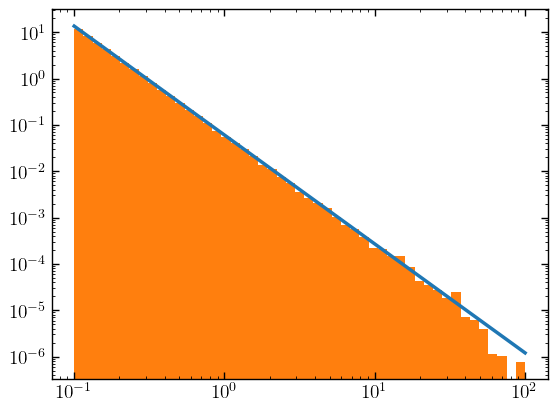

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Test __init__
imf = SalpeterIMF(-2.35, normalisation_value=1000)

# Test integrate
print(f"There are {imf.integrate(0.1, 100):.1f} stars.")

# Test integrate_product
print(f"The total mass is {imf.integrate_product(0.1, 100):.1f} solar masses.")

# Test __call__ (by plotting)
M = np.geomspace(0.1, 100)
imf = SalpeterIMF(-2.35)  # Default normalisation of corresponds to pdf. That w
plt.loglog(M, imf(M))

# Test inverse_cdf (by generating random masses)
random_masses = imf.inverse_cdf(np.random.random(100_000))
plt.hist(random_masses, density=True, bins=M)
plt.show()